# Transformation of likelihood with change of random variable

In this notebook we will be looking at how the likelihood and likelihood ratio transform under a change of variables for the random variable. In particular we will consider $X\sim P_X(X|\sigma) := N(\mu=1,\sigma)$ and $Q = 1/X$. We will also use automatic differentiation to calculate $P_Q(Q|\sigma)$. 

by Kyle Cranmer, September 16, 2020

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 15})
#rcParams.update({'font.size': 18,'text.usetex': True})
rcParams['figure.figsize'] = 12,6

In [2]:
true_sigma=0.3
true_mean = 1.5
N = 10000

In [3]:
def my_family_of_pdfs_for_X(x, sigma):
    #return 1./np.sqrt(2.*np.pi)/sigma * np.exp( -(x-mu)**2/2/sigma**2 )
    return norm.pdf(x,loc=true_mean, scale=sigma)

In [4]:
# Generate a lot of synthetic data for visualizing distribution 
x_for_hist = np.random.normal(true_mean, true_sigma, N)

In [5]:
# Generate a small synthetic data set
x_for_data = norm.rvs(loc=true_mean, scale=true_sigma, size=15)
x_for_data

array([1.17733685, 0.91609765, 1.34402892, 1.51737403, 1.7463451 ,
       1.80588216, 1.48037408, 1.42523643, 1.41963129, 0.75009037,
       1.80771715, 1.48806499, 1.27239626, 1.57353765, 1.61308992])

In [6]:
x_for_plot = np.linspace(0.1,3,100)

In [7]:
likelihood_i = my_family_of_pdfs_for_X(x_for_data, true_sigma)

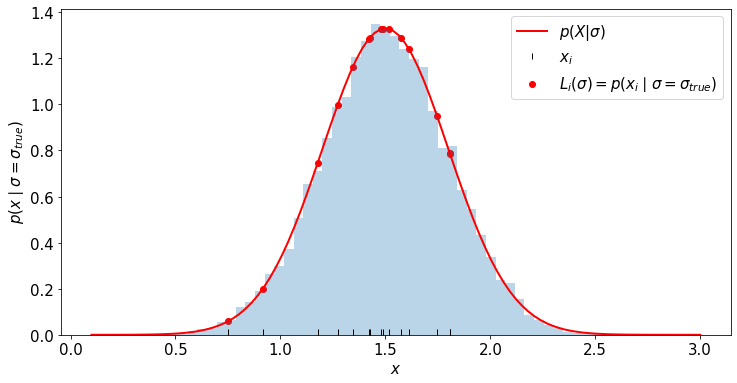

In [8]:
_ = plt.hist(x_for_hist, bins=50, density=True, alpha=.3)
plt.plot(x_for_plot, my_family_of_pdfs_for_X(x_for_plot, true_sigma), c='r', label=r'$p(X|\sigma)$',lw=2)
plt.scatter(x_for_data, likelihood_i, c='r', label=r'$L_i(\sigma) = p(x_i \mid \sigma=\sigma_{true})$')
plt.plot(x_for_data, [0.01]*len(x_for_data), '|', color='k', label=r'$x_i$')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x \mid \sigma=\sigma_{true}$)')
plt.legend()

In [9]:
def q(x):
    return 1/x

In [10]:
q_for_hist = q(x_for_hist)
q_for_plot = q(x_for_plot)
q_for_data = q(x_for_data)

In [11]:
from jax import grad, vmap
import jax.numpy as np

In [12]:
#define the gradient with grad(q)
dq = vmap(grad(q))  #dq is a new python function
print(dq(np.array([.5]))) # should be -4

[-4.]


/Users/cranmer/anaconda3/envs/stats-book-2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [13]:
def my_family_of_pdfs_for_Q(q, sigma):
    #use change of variables formua
    x = 1/q
    base_pdf = my_family_of_pdfs_for_X(x, sigma)
    jacobian = np.abs(dq(x))
    return base_pdf/jacobian

In [14]:
import seaborn as sns

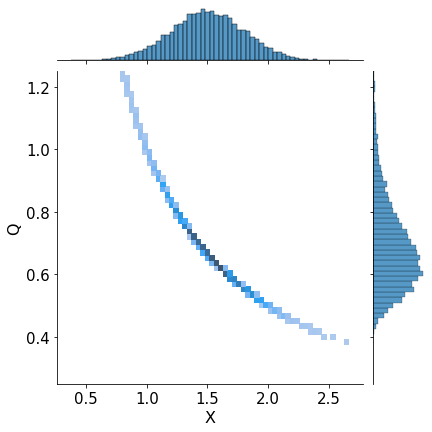

In [15]:
a_plot = sns.jointplot(x=x_for_hist, y=q_for_hist, kind="hist", fill=True)
a_plot.ax_marg_y.set_ylim(0.25, 1.25)
a_plot.set_axis_labels('X', 'Q', fontsize=16)

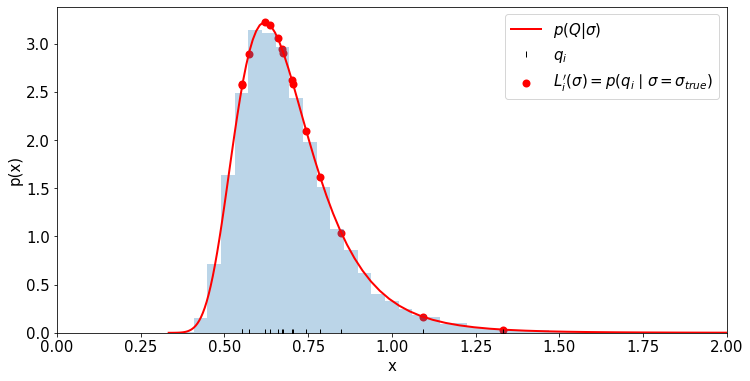

In [16]:
_ = plt.hist(q_for_hist, bins=np.linspace(0,2,50), density=True, alpha=.3)
plt.plot(q_for_plot, my_family_of_pdfs_for_Q(q_for_plot, true_sigma), c='r', lw=2, label=r'$p(Q|\sigma)$')
plt.scatter(q_for_data, my_family_of_pdfs_for_Q(q_for_data, true_sigma), c='r', lw=2, label=r'$L^\prime_i(\sigma) = p(q_i \mid \sigma=\sigma_{true})$')
plt.plot(q_for_data, [0.01]*len(q_for_data), '|', color='k', label=r'$q_i$')
plt.xlim((0,2))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

In [21]:
def my_X_likelihood(data,sigma):
    L = 1.
    for x in data:
        L *= my_family_of_pdfs_for_X(x,sigma)
    return L

'''
import numpy as np
def my_Q_likelihood(data,sigma):
    """This is a plane native python way to return array of likelihood values for each sigma"""
    ret = 0.*sigma
    for i, s in enumerate(sigma):
        ret[i] = np.prod(my_family_of_pdfs_for_Q(data,s))
    return ret
'''


#import jax.numpy as np
def my_Q_likelihood(data,sigma):
    """this is a faster way of acheiving the above with broadcasting"""
    data_ = np.tile(data, sigma.size)
    sigma_ = np.repeat(sigma, data.size)
    return np.prod(my_family_of_pdfs_for_Q(data_,sigma_).reshape(sigma.size,data.size),axis=1)

In [22]:
sigma_for_plot = np.linspace(.1,1)

In [23]:
x_likelihood = my_X_likelihood(x_for_data, sigma_for_plot)

In [24]:
q_likelihood = my_Q_likelihood(q_for_data, sigma_for_plot)

In [50]:
likelihood_offset = -2.*np.log(x_likelihood)[0]+2.*np.log(q_likelihood)[0]
print('observed offset is ', likelihood_offset)

observed offset is  19.63295


In [51]:
def predict_offset_from_jacobian(data):
    return 2*np.sum(np.log(1./np.abs(dq(data))))

print("predicted offset is ", predict_offset_from_jacobian(x_for_data))

predicted offset is  19.632957


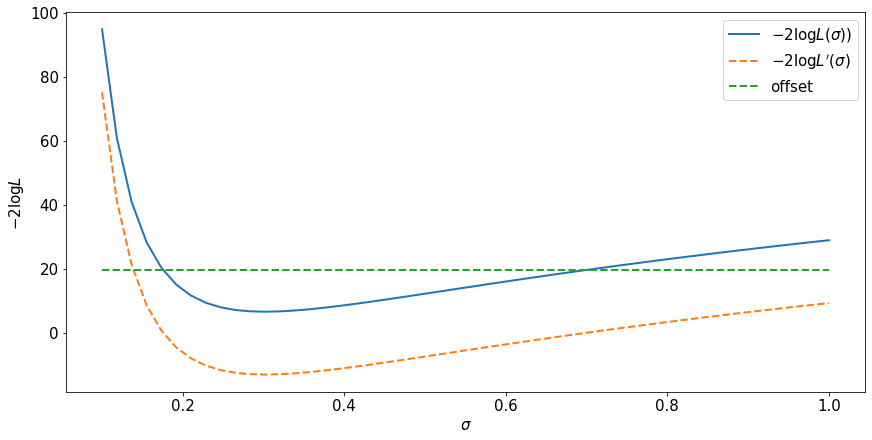

In [52]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(sigma_for_plot, -2.*np.log(x_likelihood), label=r'$-2 \log L(\sigma))$', lw=2)
ax.plot(sigma_for_plot, -2.*np.log(q_likelihood), label=r'$-2 \log L^\prime(\sigma)$', ls='dashed',lw=2)
ax.plot(sigma_for_plot, np.ones(sigma_for_plot.size)*likelihood_offset, label=r'offset', ls='dashed',lw=2)
ax.set_ylabel(r'$-2 \log L$')
ax.set_xlabel(r'$\sigma$')
ax.legend()

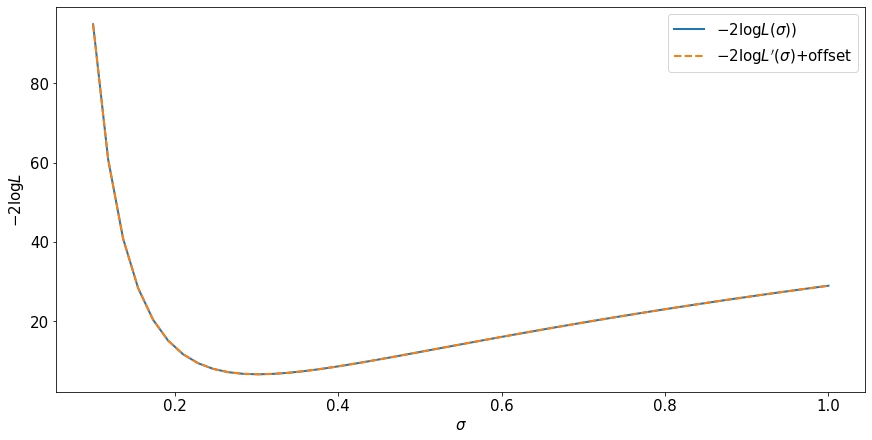

In [53]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(sigma_for_plot, -2.*np.log(x_likelihood), label=r'$-2 \log L(\sigma))$', lw=2)
ax.plot(sigma_for_plot, -2.*np.log(q_likelihood)+likelihood_offset, label=r'$-2 \log L^\prime(\sigma)$+offset', ls='dashed',lw=2)
ax.set_ylabel(r'$-2 \log L$')
ax.set_xlabel(r'$\sigma$')
ax.legend()

## Observations

The likelihood **is not** invariant to a change of variables for the random variable because there is a jacobian factor.

The likelihood ratio **is invariant** to a change of variables for the random variable because the jacobian factors cancel.

The maximum likelihood estimate **is invariant**.

Regions of the parameter space defined by level sets of the likelihood ratio (or log likelihhood ratio) **are invariant**.

